# Find out on which weekday people bike the most with groupby and aggregate

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
!pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", reset=True)

SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/281e55cb3425360e464682cfb4672fcb.sqlite



# Data owner: upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.service.project.project import Project
from syft.util.util import autocache, PANDAS_DATA

In [6]:
df = pd.read_csv(autocache(f"{PANDAS_DATA}/bikes.csv"), sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


## Create mock data

In [7]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [8]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(df))],
                    data=[get_mock_row(i) for i in range(len(df))],
                    columns=df.columns)

Upload the data

In [9]:
dataset = sy.Dataset(name="bikes2",
                     asset_list=[sy.Asset(name="bikes", data=df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]

Uploading: bikes


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## create Data scientist

In [10]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data Scientist: create result pointer

## Download mock and submit project

### Get mock

In [11]:
ds = guest_domain_client.datasets[0]

In [12]:
asset = ds.assets["bikes"]

In [13]:
asset

```python
Asset: bikes
Pointer Id: 5b752edcec4240508aadea3045ab2d81
Description: None
Total Data Subjects: 0
Shape: (310, 9)
Contributors: 0

```

In [14]:
bikes_pointer = asset.mock

### Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

propagating
propagating
281e55cb3425360e464682cfb4672fcb


```python
Pointer
```
<AxesSubplot: >

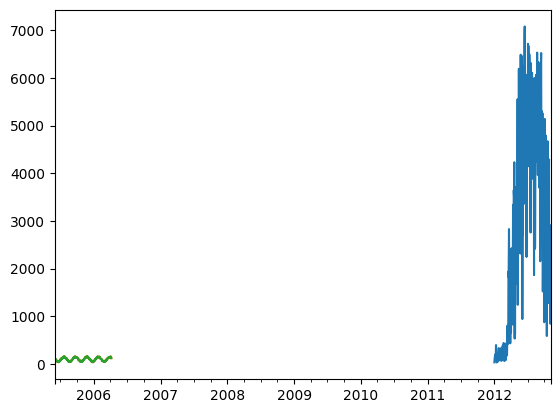

In [15]:
bikes_pointer['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [16]:
berri_bikes_pointer = bikes_pointer[['Berri 1']].copy()

propagating
propagating
281e55cb3425360e464682cfb4672fcb


In [17]:
berri_bikes_pointer[:5]

propagating


,Berri 1
2005-06-01,109
2005-06-02,97
2005-06-03,108
2005-06-04,88
2005-06-05,106


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [18]:
berri_bikes_pointer.index

propagating
281e55cb3425360e464682cfb4672fcb


```python
Pointer
```
DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [19]:
berri_bikes_pointer.index.day

propagating
281e55cb3425360e464682cfb4672fcb
propagating
None


```python
Pointer
```
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [20]:
berri_bikes_pointer.index.weekday

propagating
281e55cb3425360e464682cfb4672fcb
propagating
None


```python
Pointer
```
Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [21]:
berri_bikes_pointer

,Berri 1
2005-06-01,109
2005-06-02,97
2005-06-03,108
2005-06-04,88
2005-06-05,106
...,...
2006-04-02,156
2006-04-03,132
2006-04-04,152
2006-04-05,148


In [22]:
d1 = berri_bikes_pointer.syft_action_data
d2 = berri_bikes_pointer.index.weekday.syft_action_data

propagating
281e55cb3425360e464682cfb4672fcb
propagating
None


In [23]:
d1['weekday'] = d2


In [25]:
d1

,Berri 1,weekday
2005-06-01,109,2
2005-06-02,97,3
2005-06-03,108,4
2005-06-04,88,5
2005-06-05,106,6
...,...,...
2006-04-02,156,6
2006-04-03,132,0
2006-04-04,152,1
2006-04-05,148,2


In [26]:
berri_bikes_pointer['weekday'] = berri_bikes_pointer.index.weekday


propagating
281e55cb3425360e464682cfb4672fcb
propagating
None
propagating


In [28]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

In [29]:
berri_bikes_pointer.get_from(root_domain_client)

,Berri 1
Date,
2012-01-01,35
2012-01-02,83
2012-01-03,135
2012-01-04,144
2012-01-05,197
...,...
2012-11-01,2405
2012-11-02,1582
2012-11-03,844


This should be updated

We need to implement \_\_setitem\_\_ properly

In [27]:
berri_bikes_pointer

,Berri 1,weekday
2005-06-01,109,2
2005-06-02,97,3
2005-06-03,108,4
2005-06-04,88,5
2005-06-05,106,6
...,...,...
2006-04-02,156,6
2006-04-03,132,0
2006-04-04,152,1
2006-04-05,148,2


In [ ]:
import pandas

In [ ]:
pandas.core.indexes.numeric.Int64Index([1,2,3]).values

In [21]:
berri_bikes_pointer.loc[:,'weekday'] = berri_bikes_pointer.index.weekday
berri_bikes_pointer[:5]

propagating
281e55cb3425360e464682cfb4672fcb
propagating
None
propagating
281e55cb3425360e464682cfb4672fcb
propagating
propagating


,Berri 1,weekday
2005-06-01,85,2
2005-06-02,30,3
2005-06-03,27,4
2005-06-04,80,5
2005-06-05,27,6


### Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [22]:
res = berri_bikes_pointer.groupby('weekday')

> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(379)execute()
    378             ipdb.set_trace()
--> 379             print(context.node.id)
    380 

ipdb> ll
    369     @service_method(path="action.execute", name="execute", roles=GUEST_ROLE_LEVEL)
    370     def execute(
    371         self, context: AuthedServiceContext, action: Action
    372     ) -> Result[ActionObject, Err]:
    373         """Execute an operation on objects in the action store"""
    374         # relative
    375         from .plan import Plan
    376         if action.op == "groupby":
    377             import ipdb
    378             ipdb.set_trace()
--> 379             print(context.node.id)
    380 
    381         if action.action_type == ActionType.CREATEOBJECT:
    382             result_action_object = Ok(action.create_object)
    383         elif action.action_type == ActionType.FUNCTION:
    384             result_action_object = self.call_function(context,

ipdb> n
281e55cb3425360e464682cfb4672fcb
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(381)execute()
    380 
--> 381         if action.action_type == ActionType.CREATEOBJECT:
    382             result_action_object = Ok(action.create_object)

ipdb> n
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(383)execute()
    382             result_action_object = Ok(action.create_object)
--> 383         elif action.action_type == ActionType.FUNCTION:
    384             result_action_object = self.call_function(context, action)

ipdb> n
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(386)execute()
    385         else:
--> 386             resolved_self = self._get(
    387                 context=context,

ipdb> n
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(387)execute()
    386             resolved_self = self._get(
--> 387          

ipdb> n
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_service.py(417)execute()
    416 
--> 417         if result_action_object.is_err():
    418             return Err(

ipdb> result_action_object
Err("Failed executing action ActionObject PandasDataFrameObject[a84..8].groupby(fcb..b,), result is an error: 'weekday'")
ipdb> resolved_self
syft.types.twin_object.TwinObject
ipdb> resolved_self.mock
TwinPointer(Mock):
            Berri 1
2005-06-01       85
2005-06-02       30
2005-06-03       27
2005-06-04       80
2005-06-05       27
...             ...
2006-04-02       75
2006-04-03      109
2006-04-04      106
2006-04-05      104
2006-04-06       83

[310 rows x 1 columns]
ipdb> resolved_self.mock.groupby("weekday")
281e55cb3425360e464682cfb4672fcb
*** KeyError: 'weekday'
ipdb> q
propagating
281e55cb3425360e464682cfb4672fcb
> /Users/koen/workspace/PySyft/packages/syft/src/syft/service/action/action_object.py(371)propagate_node_uid()
    370 
--> 371       

In [ ]:
res.syft_node_uid

In [23]:
weekday_counts_pointer = berri_bikes_pointer.groupby('weekday').aggregate(sum)
weekday_counts_pointer

,Berri 1
weekday,
0,4305
1,4404
2,4535
3,4504
4,4423
5,4324
6,4293


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [23]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

```python
Pointer
```
<AxesSubplot: xlabel='weekday'>

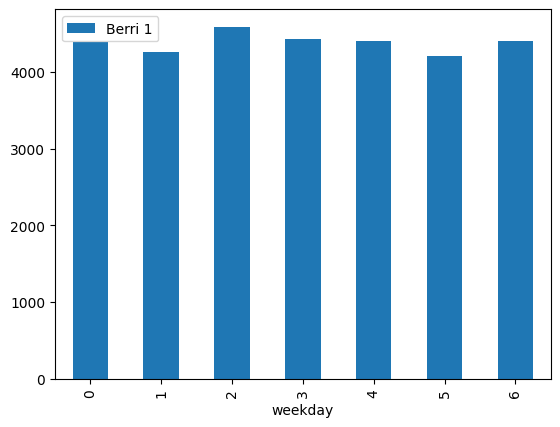

In [24]:
weekday_counts_pointer.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

### Putting it together

Now we want to request the real result.

In [25]:
weekday_counts_pointer.request(guest_client)

Exception: <class 'syft.store.linked_obj.LinkedObject'> Requires an object UID

In [31]:
# Todo, fix indexes in function

In [ ]:
@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

Request code execution

In [ ]:
req = guest_domain_client.api.services.code.request_code_execution(get_bike_hist)

In [ ]:
submitted_code = guest_domain_client.code[0]

In [ ]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [ ]:
new_project = sy.Project(name="Pandas Chapter 4",
                         description="Hi, I would like to plot histogram of bikers per weekday")

In [ ]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [ ]:
guest_domain_client.submit_project(new_project)

# Data owner: execute syft_function

In [ ]:
from syft import MessageStatus

In [ ]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Get messages

In [ ]:
messages = root_domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [ ]:
messages

In [ ]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [ ]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [ ]:
func

In [ ]:
get_col_user_function = func.unsafe_function

In [ ]:
real_data = root_domain_client.datasets[0].assets[0].data

In [ ]:
real_result = get_col_user_function(bikes=real_data)

In [ ]:
bikes=real_data.syft_action_data
berri_bikes = bikes[['Berri 1']].copy()
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
real_result = weekday_counts

In [ ]:
real_result[:3]

In [ ]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [ ]:
asset = guest_client.datasets[0].assets[0]

In [ ]:
guest_client.api.services.code[0].status

In [ ]:
real_result = guest_client.api.services.code.get_bike_hist(bikes=asset)
real_result.plot(kind="bar")

In [ ]:
node.land()